In [1]:
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import os
import sys
import re
sys.path.insert(0,'/workspace/lang-detect/')

from src import utils

In [2]:
data_path = "/workspace/lang-detect/txt/"
dir_list = os.listdir(data_path)
print(dir_list)

['sl', 'es', 'el', 'nl', 'hu', 'it', 'bg', 'sk', 'da', 'sv', 'cs', 'lt', 'de', 'en', 'pl', 'fr', 'fi', 'lv', 'pt', 'et', 'ro']


In [3]:
def read_data(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()
        if len(lines) > 1:
            return lines[1].strip("\n")
        return None

In [4]:
%%time
data, labels = [], []
for dir_name in dir_list:
    files_list = os.listdir(data_path + dir_name)
    for f in files_list:
        sent = read_data(data_path + dir_name + "/" + f)
        if sent:
            data.append(sent)
            labels.append(dir_name)

CPU times: user 5.75 s, sys: 7.14 s, total: 12.9 s
Wall time: 44.1 s


In [5]:
print("Length of data", len(data))

('Length of data', 186458)


In [6]:
%%time
for i in range(len(data)):
    data[i] = utils.preprocess(data[i])

CPU times: user 1.44 s, sys: 0 ns, total: 1.44 s
Wall time: 1.44 s


In [7]:
len(data)

186458

In [9]:
sentences = []
for i in range(len(data)):
    x = utils.create_n_gram(data[i], 4)
    sentences.append(x.split())

In [10]:
# Create word_to_index and index_to_word mapping
word_to_index, index_to_word = {}, {}

index = 1
for sent in sentences:
    for token in sent:
        if token not in word_to_index:
            word_to_index[token] = index
            index_to_word[index] = token
            index += 1

print("Vocabulary size", index-1)

('Vocabulary size', 82934)


In [11]:
# Change words to their index
train_x = []
for sent in sentences:
    x = []
    for token in sent:
        x.append(word_to_index[token])
    train_x.append(x)

In [12]:
# Check distribution of length of sentences
lens = {}
for sent in train_x:
    if len(sent) in lens:
        lens[len(sent)] += 1
    else:
        lens[len(sent)] = 1

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline  

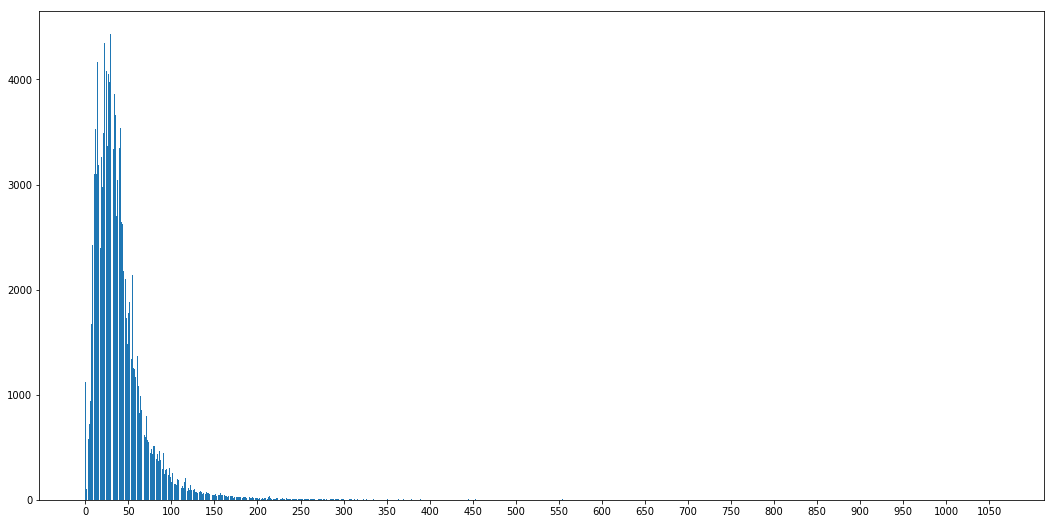

In [14]:
plt.figure(figsize=(18,9))
plt.bar(lens.keys(), lens.values())
plt.xticks(np.arange(min(lens.keys()), max(lens.keys())+1, 50))
plt.show()

In [15]:
# check number of sentences with length more than 100, 200, 300
n_100, n_200, n_300 = 0, 0, 0
for k,v in lens.items():
    if k >= 300:
        n_300 += v
    if k >= 200:
        n_200 += v
    if k >= 100:
        n_100 += v
print(n_100, n_200, n_300)

(8329, 1158, 257)


In [16]:
# check number of sentences with length more than 500
n_500 = 0
for k,v in lens.items():
    if k >= 250:
        n_500 += v
print(n_500)

514


**There are some very long sentences but I don't want to loose information. What I am going to do is, truncate the sentences with length more than 250 and create a new sentence from index 251 to 500 and so on. Since I have included 4-gram tokens only in this data, some noise might get added at the start and end of new sentences, but the model should not get affected by that.**

In [17]:
print(len(train_x), len(labels))

(186458, 186458)


In [18]:
train_x_trunc, train_y_trunc = [], []

max_len = 250

for ind, sent in enumerate(train_x):
    while(len(sent) > max_len):
        train_x_trunc.append(sent[:max_len])
        train_y_trunc.append(labels[ind])
        sent = sent[max_len:]
    train_x_trunc.append(sent)
    train_y_trunc.append(labels[ind])

print(len(train_x_trunc), len(train_y_trunc))

(187021, 187021)


In [22]:
classes = {}
for ind, c in enumerate(list(set(train_y_trunc))):
    classes[c] = ind
print(classes)

{'el': 0, 'fr': 1, 'bg': 2, 'nl': 3, 'es': 20, 'pt': 5, 'da': 19, 'de': 8, 'sv': 7, 'it': 9, 'lv': 6, 'lt': 13, 'en': 14, 'sk': 11, 'sl': 16, 'cs': 17, 'et': 12, 'hu': 10, 'ro': 4, 'fi': 18, 'pl': 15}


In [23]:
for ind in range(len(train_y_trunc)):
    train_y_trunc[ind] = classes[train_y_trunc[ind]]
print(set(train_y_trunc))

set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])


In [24]:
# Check distribution of length of sentences
lens = {}
for sent in train_x_trunc:
    if len(sent) in lens:
        lens[len(sent)] += 1
    else:
        lens[len(sent)] = 1

In [25]:
buckets = [10*x for x in range(1,26)]
buckets_data_sum = {}
for k, v in lens.items():
    for x in buckets:
        if k <= x:
            if x in buckets_data_sum:
                buckets_data_sum[x] += v
            else:
                buckets_data_sum[x] = v
            break
buckets_data_sum

{10: 13859,
 20: 33441,
 30: 39557,
 40: 34036,
 50: 22827,
 60: 14012,
 70: 8451,
 80: 5394,
 90: 4408,
 100: 2697,
 110: 1789,
 120: 1571,
 130: 985,
 140: 689,
 150: 594,
 160: 485,
 170: 356,
 180: 273,
 190: 205,
 200: 177,
 210: 152,
 220: 162,
 230: 111,
 240: 102,
 250: 688}

In [26]:
sum(buckets_data_sum.values())

187021

In [27]:
from collections import defaultdict

# Create batch data
batch_data = defaultdict(list)
batch_label = defaultdict(list)
PAD_ID = 0

for ind, sent in enumerate(train_x_trunc):
    for x in buckets:
        if len(sent) <= x:
            sent += [PAD_ID]*(x - len(sent))
            batch_data[x].append(sent)
            batch_label[x].append(train_y_trunc[ind])
            break

In [28]:
batch_data[10][:10]

[[304, 305, 306, 292, 307, 70, 308, 0, 0, 0],
 [360, 58, 59, 60, 61, 62, 63, 143, 0, 0],
 [360, 58, 59, 60, 61, 62, 63, 143, 0, 0],
 [123, 190, 191, 192, 193, 194, 0, 0, 0, 0],
 [689, 690, 691, 692, 693, 694, 695, 308, 0, 0],
 [360, 58, 59, 60, 61, 62, 63, 143, 0, 0],
 [689, 690, 691, 692, 693, 694, 695, 308, 0, 0],
 [849, 850, 851, 499, 852, 853, 854, 855, 856, 857],
 [360, 58, 59, 60, 61, 62, 63, 143, 0, 0],
 [689, 690, 691, 692, 693, 694, 695, 308, 0, 0]]

In [30]:
# Convert to numpy array each key
for key in batch_data:
    batch_data[key] = np.array(batch_data[key])
    batch_label[key] = np.array(batch_label[key])

In [31]:
import pickle

with open('../data/batch_data.npy', 'w') as f:
    pickle.dump(batch_data, f)

with open('../data/batch_label.npy', 'w') as f:
    pickle.dump(batch_label, f)

In [24]:
# Create embedding matrix
wordvec = Word2Vec.load("../word-vectors/word2vec")
wordvec.wv.most_similar("the")

[('and', 0.7841068506240845),
 ('on', 0.759896993637085),
 ('of', 0.7271450757980347),
 ('fety', 0.7232488393783569),
 ('shor', 0.7075440883636475),
 ('ourt', 0.7063887119293213),
 ('din', 0.7044749855995178),
 ('to', 0.7022175192832947),
 ('afet', 0.6996240019798279),
 ('from', 0.691842794418335)]

In [31]:
wordvec.wv.get_vector("the")

array([ 1.572987  ,  2.735609  ,  0.64099294,  2.2075114 ,  1.810811  ,
        1.320163  , -2.0518892 ,  0.6383124 ,  1.5301269 , -1.8204945 ,
        0.87725013, -0.9785473 , -2.4711254 ,  1.0467197 , -0.43357244,
       -0.37392902, -3.4508646 , -0.87442845, -0.46869975,  0.5089424 ,
        2.6256225 , -2.4643495 ,  2.2892654 , -0.29851928,  1.6183301 ,
        2.48107   ,  0.21856466, -0.5068994 , -1.7413462 , -1.1562588 ,
       -2.8360653 , -3.4761653 ,  2.6883032 ,  1.8478122 , -0.94803345,
       -1.5750355 , -1.3575674 , -0.49536067,  1.0757141 ,  0.5275996 ,
       -1.9814926 , -2.2281053 , -1.6347038 ,  1.3217245 ,  1.9017682 ,
        2.1075456 , -0.41398883,  3.4355843 , -0.00692933, -2.4787297 ,
       -0.9633201 ,  2.0556319 ,  0.47517714, -4.1312013 ,  1.4229084 ,
        0.8764478 , -0.10577996, -2.3738363 , -0.73883134, -1.2658491 ,
       -2.68997   ,  0.40155867,  0.3440695 ,  2.4353578 , -0.28661215,
        1.7299148 , -3.2678797 , -0.93289286,  0.552735  ,  3.13

Tokens are indexed starting from 1. '0' is for the padding. Vector for 0 will be zero-vector.

In [33]:
vocab_size, embed_size = wordvec.wv.vectors.shape

In [38]:
sorted_word_to_index = sorted(zip(word_to_index.keys(), word_to_index.values()), key=lambda x: x[1])
sorted_word_to_index[0]

('pred', 1)

In [41]:
embedding_matrix = []
embedding_matrix.append([0.]*embed_size)

for key, index in sorted_word_to_index:
    embedding_matrix.append(wordvec.wv.get_vector(key))

In [42]:
print(len(embedding_matrix), len(embedding_matrix[0]))

(82935, 100)


In [43]:
embedding_matrix = np.array(embedding_matrix)

import pickle
with open('../data/embedding_matrix.npy', 'w') as f:
    pickle.dump(embedding_matrix, f)

In [44]:
with open('../data/embedding_matrix.npy', 'r') as f:
    ld = pickle.load(f)
ld.shape

(82935, 100)